# Requirements

In [104]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [17]:
df = pd.read_csv('datasets/climate-data-lab4.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [21]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(keys=['date'], inplace=True)
df.sort_index(inplace=True)
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [23]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Explore the dataset using visualizations of your choice.

<Axes: >

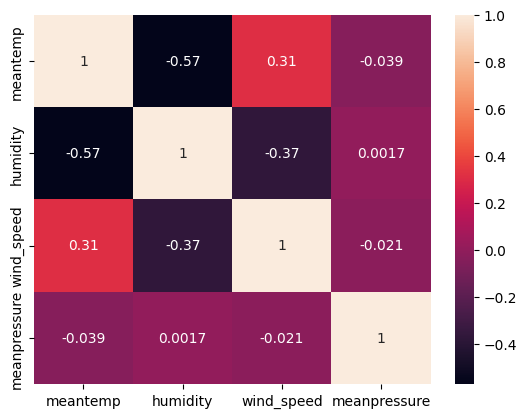

In [30]:
sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='date', ylabel='humidity'>

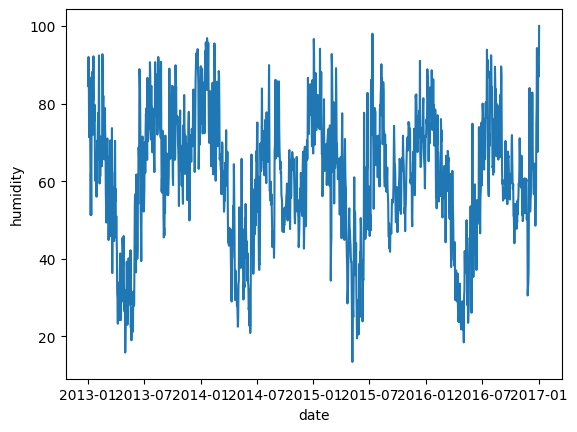

In [34]:
sns.lineplot(df["humidity"])

<Axes: xlabel='date', ylabel='wind_speed'>

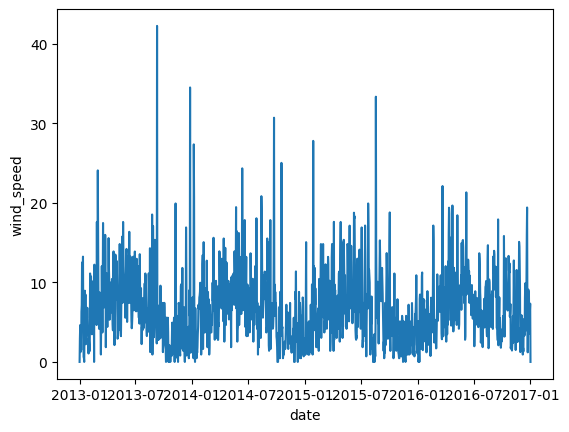

In [36]:
sns.lineplot(df["wind_speed"])

<Axes: xlabel='date', ylabel='meanpressure'>

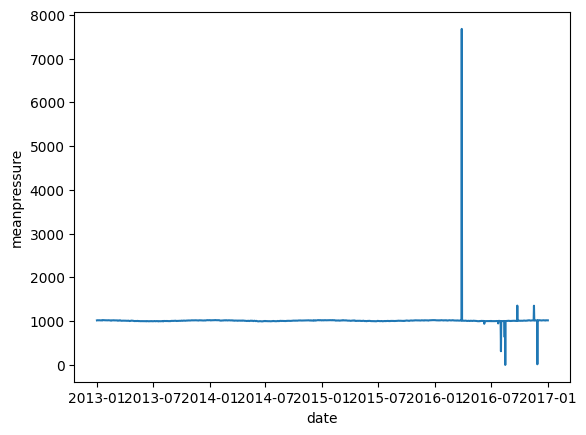

In [38]:
sns.lineplot(df["meanpressure"])

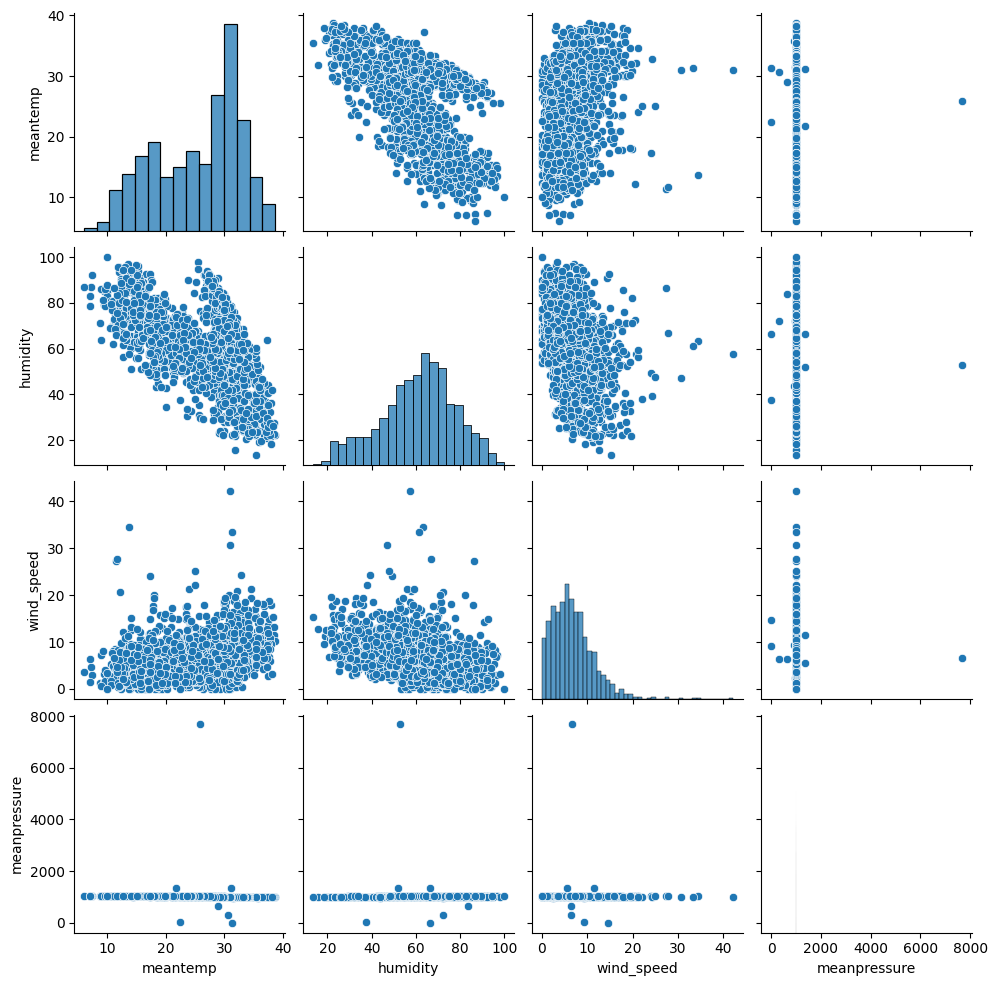

In [40]:
sns.pairplot(df)

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [44]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [46]:
features = ["humidity", "wind_speed", "meanpressure"]
target = "meantemp"

In [48]:
lags = range(3, 0, -1)
list(lags)

[3, 2, 1]

In [56]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df

,meantemp,humidity,wind_speed,meanpressure,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
date,,,,,,,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,7.400000,92.000000,2.980000,1017.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.500000,0.000000,1015.666667,10.000000
2013-01-03,7.166667,87.000000,4.633333,1018.666667,NaN,NaN,NaN,NaN,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000
2013-01-04,8.666667,71.333333,1.233333,1017.166667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
2016-12-29,15.238095,87.857143,6.000000,1016.904762,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
2016-12-30,14.095238,89.666667,6.266667,1017.904762,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095


In [58]:
df.drop(columns=features, inplace=True)
df.dropna(axis=0, inplace=True)
df

,meantemp,humidity_3,wind_speed_3,meanpressure_3,meantemp_3,humidity_2,wind_speed_2,meanpressure_2,meantemp_2,humidity_1,wind_speed_1,meanpressure_1,meantemp_1
date,,,,,,,,,,,,,
2013-01-04,8.666667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
2013-01-06,7.000000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
2013-01-07,7.000000,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
2013-01-08,8.857143,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
2016-12-29,15.238095,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
2016-12-30,14.095238,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [62]:
X, y = df.drop(columns=[target]), df[target]

In [64]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [68]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [70]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [74]:
lag = 3
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(1313, 3, 4)

In [76]:
train_X = train_X.reshape((train_X.shape[0], lag, (train_X.shape[1] // lag)))
test_X = test_X.reshape((test_X.shape[0], lag, (test_X.shape[1] // lag)))

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [88]:
train_X.shape

(1313, 3, 4)

In [90]:
model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(16, activation="relu", return_sequences=True),
    LSTM(8, activation="relu"),
    Dense(1, activation="linear")
])

In [92]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,153 (8.41 KB)

 Trainable params: 2,153 (8.41 KB)

 Non-trainable params: 0 (0.00 B)

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [94]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [96]:
history = model.fit(train_X, train_y, validation_split=0.20, epochs=16, batch_size=16, shuffle=False)

Epoch 1/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3482 - mean_squared_error: 0.3482 - val_loss: 0.3485 - val_mean_squared_error: 0.3485
Epoch 2/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.1893 - val_mean_squared_error: 0.1893
Epoch 3/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0887 - mean_squared_error: 0.0887 - val_loss: 0.0510 - val_mean_squared_error: 0.0510
Epoch 4/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 5/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 6/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 7/16
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0099 - val_mean_

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

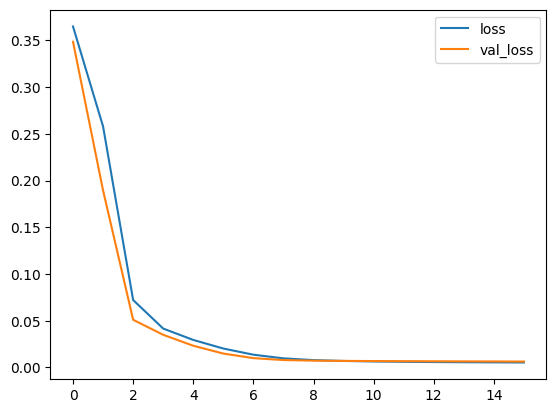

In [98]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

Use the trained model to make predictions for the test set.

In [100]:
pred_y = model.predict(test_X)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [102]:
pred_y = scaler.inverse_transform(pred_y)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [106]:
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(1.242897141445816, 2.679124241809825, 0.9177247618459489)

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

<Axes: xlabel='date'>

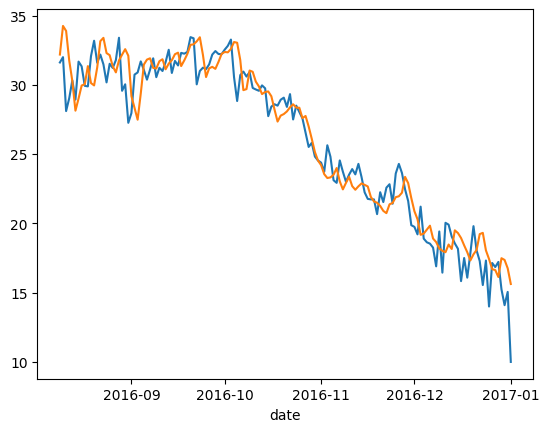

In [108]:
sns.lineplot(x=test_y.index, y=test_y.values)
sns.lineplot(x=test_y.index, y=pred_y.flatten())